In [7]:
from rasterio.features import shapes
from shapely.geometry import shape, MultiPolygon, Polygon, box
import geopandas as gpd
import ocsmesh
from osgeo import gdal
import rasterio
import pandas as pd

In [8]:
def remove_interiors(poly):
    """
    Close polygon holes by limitation to the exterior ring.

    Arguments
    ---------
    poly: shapely.geometry.Polygon
        Input shapely Polygon

    Returns
    ---------
    Polygon without any interior holes
    """
    if poly.interiors:
        return Polygon(list(poly.exterior.coords))
    else:
        return poly


def pop_largest(gs):
    """
    Pop the largest polygon off of a GeoSeries

    Arguments
    ---------
    gs: geopandas.GeoSeries
        Geoseries of Polygon or MultiPolygon objects

    Returns
    ---------
    Largest Polygon in a Geoseries
    """
    geoms = [g.area for g in gs]
    return geoms.pop(geoms.index(max(geoms)))


def close_holes(geom):
    """
    Remove holes in a polygon geometry

    Arguments
    ---------
    gseries: geopandas.GeoSeries
        Geoseries of Polygon or MultiPolygon objects

    Returns
    ---------
    Largest Polygon in a Geoseries
    """
    if isinstance(geom, MultiPolygon):
        ser = gpd.GeoSeries([remove_interiors(g) for g in geom])
        big = pop_largest(ser)
        outers = ser.loc[~ser.within(big)].tolist()
        if outers:
            return MultiPolygon([big] + outers)
        return Polygon(big)
    if isinstance(geom, Polygon):
        return remove_interiors(geom)

In [9]:
def eddy(path,hmax,outdir):
    r = ocsmesh.Raster(path)

    shps = shapes(r.get_values(band=True), transform=r.src.transform)
    polys = []
    sids = []  # For contours this will be elev levels
    for shp, sid in shps:
        if sid<=hmax:
            polys.append(shape(shp))
            sids.append(sid)

    gdf = gpd.GeoDataFrame(
        geometry=polys,
        data={'sid': sids},
        crs=r.crs
    ).dropna().dissolve()

    gdf.to_file(outdir)

In [10]:
def land_mask(path,hmin,outdir):
    r = ocsmesh.Raster(path)

    shps = shapes(r.get_values(band=True), transform=r.src.transform)
    polys = []
    sids = []  # For contours this will be elev levels
    for shp, sid in shps:
        if sid>=hmin:
            polys.append(shape(shp))
            sids.append(sid)

    gdf = gpd.GeoDataFrame(
        geometry=polys,
        data={'sid': sids},
        crs=r.crs
    ).dropna().dissolve()

    gdf.to_file(outdir)

In [11]:
def get_survey_shapes(path,hmax,hmin,outdir):
    r = ocsmesh.Raster(path)

    shps = shapes(r.get_values(band=True), transform=r.src.transform)
    polys = []
    sids = []  # For contours this will be elev levels
    for shp, sid in shps:
        if sid>=hmin and sid<=hmax:
            polys.append(shape(shp))
            sids.append(sid)

    gdf = gpd.GeoDataFrame(
        geometry=polys,
        data={'sid': sids},
        crs=r.crs
    ).dissolve(by='sid').dropna()#.dropna()#.dissolve()

    gdf.to_file(outdir)

In [15]:
def calculate_slope(DEM):
    gdal.DEMProcessing('slope.tif', DEM, 'slope')
    with rasterio.open('slope.tif') as dataset:
        slope=dataset.read(1)
    return slope
    gdal.DEMProcessing('slope.tif', DEM, 'slope',scale=111120)
    with rasterio.open('slope.tif') as dataset:
        slope=dataset.read(1)
    return slope

## Find non-eddy zones:

In [16]:
hmax=0
hmin=-1000
interv=10

In [17]:
#rast_path =r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\dem\smaller_domain\GEBCO_28_Oct_2024_cea7192fe05d/gebco_2024_n26.0_s22.0_w-82.0_e-78.0.tif"
rast_path =r"C:/Users/Felicio.Cassalho/Work/Python_Development/Mesh/OCSMesh_Contributions/ocean_mesh/dem/small_domain/GEBCO_28_Oct_2024_994bac2e22a9/gebco_2024_n28.0_s15.0_w-90.0_e-73.0.tif"

In [18]:
#calculate_slope(rast_path)

In [19]:
slope_path=r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\slope.tif"

In [20]:
outdir = r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs"

In [83]:
get_survey_shapes(path=rast_path,hmax=hmax,hmin=hmin,outdir=outdir+r"/greater_1000_ind.shp")

In [84]:
elev = gpd.read_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/greater_1000_ind.shp")

In [85]:
for x in range(hmin,hmax,interv):
    y=x+interv
    elev.loc[(elev['sid'] >= x) & (elev['sid'] < y), 'range'] = f'{x}-{y}'

In [86]:
elev = elev.dissolve(by='range').dropna()

In [87]:
elev = elev.sort_values(by=['sid'],ascending=False)

In [88]:
elev.reset_index(drop=False, inplace=True)

In [89]:
elev.to_file(outdir+r"/greater_1000_by10.shp")

In [91]:
import rasterio
from rasterstats import zonal_stats

# Read the raster
with rasterio.open(slope_path) as raster:
    affine = raster.transform
    array = raster.read(1)

In [92]:
polygons = elev#.explode()

In [93]:
stats = zonal_stats(polygons, slope_path, affine=affine, stats=["median","mean"])

In [94]:
# Calculate percentage
list_median,list_mean=[],[]
for stat in stats:
    list_median.append(stat['median'])
    list_mean.append(stat['mean'])

In [95]:
# polygons["median_slope"]=list_median
polygons["mean_slope"]=list_mean

In [ ]:
polygons

<Axes: xlabel='mean_slope', ylabel='sid'>

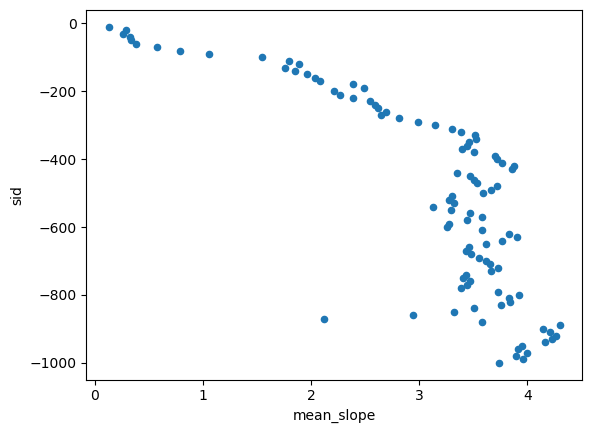

In [98]:
polygons.plot.scatter(x='mean_slope', y='sid')

In [29]:
# polygons = polygons.sort_values(by=['sid'],ascending=True)
# polygons.reset_index(drop=False, inplace=True)

In [99]:
polygons.to_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/polygons.shp")

In [47]:
polygons = gpd.read_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/polygons.shp")

In [48]:
polygons["area"] = polygons['geometry'].area

C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_5336\2290710304.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons["area"] = polygons['geometry'].area


<Axes: xlabel='area', ylabel='sid'>

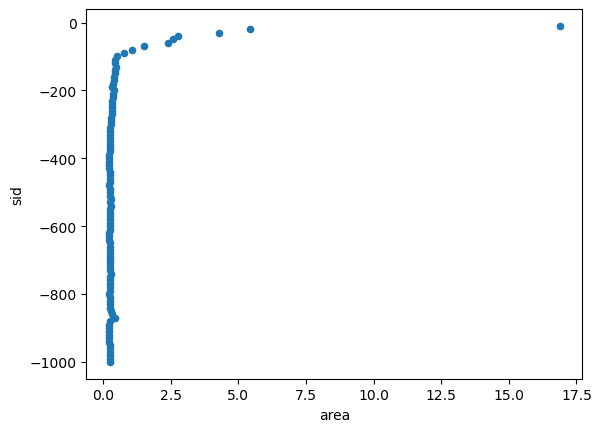

In [49]:
polygons.plot.scatter(x='area', y='sid')

In [50]:
i = 0
slope_count=0
crest = 3
while i < len(polygons):
    # row = polygons.iloc[i]
    if polygons.iloc[i]['mean_slope'] > 1:
        slope_count += 1
    else:
        slope_count = 0
    # print(i,slope_count)
    if slope_count >= crest:
        non_eddy = polygons.iloc[0:i-(crest-1)]#.dissolve()
        
        break
    i += 1

In [51]:
non_eddy.to_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/non_eddy.shp")

In [52]:
non_eddy = non_eddy.dissolve().explode()

In [53]:
non_eddy.geometry = non_eddy.geometry.apply(lambda p: close_holes(p))
non_eddy = non_eddy.dissolve().explode()
non_eddy.to_file(outdir+r"/non_eddy_nohole1.shp")

### Land mask

In [68]:
land_min=0

In [69]:
land_mask(path=rast_path,hmin=land_min,outdir=outdir+r"/land.shp")

## Find transition zones:

In [35]:
get_survey_shapes(path=slope_path,hmax=50,hmin=0,outdir=outdir+r"/allslopes.shp")

In [63]:
slope = gpd.read_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/allslopes.shp")

In [64]:
slope = slope.loc[slope['sid'] >5].dissolve().explode()

In [65]:
slope.to_file(outdir+r"/slope_morethan5.shp")

In [66]:
slope.geometry = slope.geometry.apply(lambda p: close_holes(p))
slope.to_file(outdir+r"/slope_morethan5_nohole.shp")

In [ ]:
import rasterio
from rasterstats import zonal_stats

# Read the raster
with rasterio.open(rast_path) as raster:
    affine = raster.transform
    array = raster.read(1)

In [ ]:
polygons = slope.explode()
stats = zonal_stats(polygons, array, affine=affine, stats=["min","max"])

In [ ]:
# Calculate percentage
list_min,list_max=[],[]
for stat in stats:
    list_min.append(stat['min'])
    list_max.append(stat['max'])

In [ ]:
polygons['min_elev']=list_min
polygons['max_elev']=list_max

In [ ]:
transition = polygons.loc[(polygons['max_elev'] >-100 ) & (polygons['min_elev'] < -500)]

In [ ]:
transition.to_file(outdir+r"/transition5.shp")

In [46]:
# after this I could fill all holes, and then subtract by the non-eddy regime area

## Find eddy zones:

In [28]:
eddy_max=-450

In [29]:
eddy(path=rast_path,hmax=eddy_max,outdir=outdir+r"/eddy450.shp")

In [56]:
eddy = gpd.read_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/eddy450.shp")

## Find transition zones2:

In [57]:
not_trans= pd.concat([eddy,non_eddy])
not_trans = not_trans.dissolve()

In [58]:
xmin, ymin, xmax, ymax = not_trans['geometry'].bounds.values[0]

In [59]:
shape_box = box(xmin, ymin, xmax, ymax)

In [62]:
transition = gpd.GeoDataFrame(geometry=[shape_box.symmetric_difference(not_trans.union_all())],
                               #crs=crs
                              ).dissolve().explode()

In [63]:
transition.to_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/transition.shp")

C:\Users\Felicio.Cassalho\.conda\envs\ocsmesh_161\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


In [47]:
not_eddy = pd.concat([transition,non_eddy])
not_eddy = not_eddy.dissolve()
# xmin, ymin, xmax, ymax = not_eddy['geometry'].bounds.values[0]

In [48]:
xmin, ymin, xmax, ymax = transition.dissolve()['geometry'].bounds.values[0]

In [49]:
shape_box = box(xmin, ymin, xmax, ymax)

In [50]:
other_zones = gpd.GeoDataFrame(geometry=[shape_box.symmetric_difference(not_eddy.union_all())],
                               #crs=crs
                              ).dissolve().explode()

In [51]:
other_zones.to_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/other_zones.shp")

C:\Users\Felicio.Cassalho\.conda\envs\ocsmesh_161\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


In [52]:
import rasterio
from rasterstats import zonal_stats

# Read the raster
with rasterio.open(rast_path) as raster:
    affine = raster.transform
    array = raster.read(1)

In [53]:
polygons = other_zones.explode()

In [54]:
stats = zonal_stats(polygons, array, affine=affine, stats="median")

In [55]:
# Calculate percentage
median=[]
for stat in stats:
    m = stat["median"]
    median.append(m)

In [56]:
polygons['median']=median

In [57]:
eddy = polygons.loc[(polygons["median"] <-750) ]

In [58]:
eddy.to_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/eddy.shp")

C:\Users\Felicio.Cassalho\.conda\envs\ocsmesh_161\Lib\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


In [12]:
elev.loc[(elev['sid'] > -20) & (elev['sid'] < -10), 'range'] = '-20--10'

In [14]:
elev.loc[(elev['sid'] > -30) & (elev['sid'] < -20), 'range'] = '-30--20'

In [15]:
elev.loc[(elev['sid'] > -40) & (elev['sid'] < -30), 'range'] = '-40--30'

In [16]:
elev.loc[(elev['sid'] > -50) & (elev['sid'] < -40), 'range'] = '-50--40'

In [24]:
elev = elev.dissolve(by='range').dropna()

In [25]:
elev.to_file(outdir+r"/greater_50_by10.shp")

In [29]:
calculate_slope(rast_path)

array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03,  4.8916068e-02,  9.7832069e-02, ...,
         6.2382107e+00,  6.0996137e+00, -9.9990000e+03],
       [-9.9990000e+03,  4.8916068e-02,  9.0196721e-02, ...,
         1.6019108e+00,  1.0691147e+00, -9.9990000e+03],
       ...,
       [-9.9990000e+03,  3.0937243e-02,  2.1875935e-02, ...,
         2.4457891e-01,  3.0937243e-02, -9.9990000e+03],
       [-9.9990000e+03,  4.8916068e-02,  6.5627784e-02, ...,
         5.0739527e-01,  1.4674792e-01, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [30]:
slope_path =r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\slope.tif"

In [34]:
get_survey_shapes(path=slope_path,hmax=.5,hmin=0,outdir=outdir+r"/slope05.shp")

In [37]:
slope = gpd.read_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/slope05.shp")

In [40]:
elev = gpd.read_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/greater_50.shp")

In [50]:
result = gpd.overlay(elev, slope, how='union')

C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_10168\1626583161.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 594 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = gpd.overlay(elev, slope, how='union')


In [51]:
result.to_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/result.shp")

In [63]:
#combined = pd.concat([elev.explode(),slope.explode()])

In [32]:
# import itertools
# geoms = combined['geometry'].tolist()
# union_iter = gpd.GeoDataFrame(gpd.GeoSeries([poly[0].union(poly[1]) for poly in  itertools.combinations(geoms, 2) if poly[0].union(poly[1])]), columns=['geometry'])
# union_iter.to_file(r"C:\Users\Felicio.Cassalho\Work\Python_Development\Mesh\OCSMesh_Contributions\ocean_mesh\outputs/intersection_iter.shp") 